In [1]:
from Helpers.data import Read
from Helpers.functions import Functions
from Helpers.models import Models
import pandas as pd
import numpy as np

# Réplica Paper: 
## "What causes the attention of Bitcoin" - Andrew Urquhart

# Datos
- Precios y volumen: obtenidas de www.bitcoincharts.com

<AxesSubplot:title={'center':'Retorno y Volumen'}, xlabel='Timestamp'>

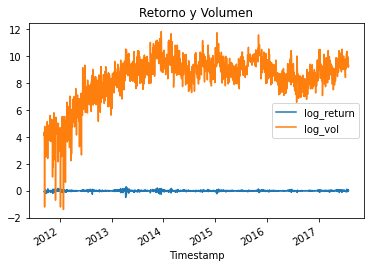

In [2]:
daily_data = Read.read_prices_volume()
daily_data[['log_return', 'log_vol']].plot(title = 'Retorno y Volumen')

- Consultas de búsqueda: obtenida de Google Trends

<AxesSubplot:title={'center':'Search Queries'}, xlabel='Mes'>

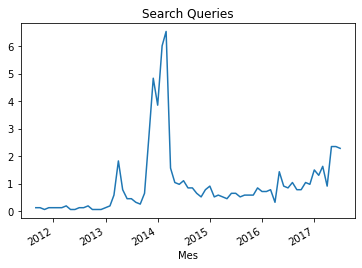

In [3]:
monthly_data = Read.read_search_queries()
# Estandarizamos las consultas de busqueda y eliminamos los ceros
stan_SQ = (monthly_data[monthly_data.SQ > 0]/monthly_data[monthly_data.SQ > 0].mean())
log_SQ = np.log(stan_SQ)
stan_SQ.plot(title = 'Search Queries', legend = '')

<AxesSubplot:title={'center':'Volatilidad Realizada'}, xlabel='Timestamp'>

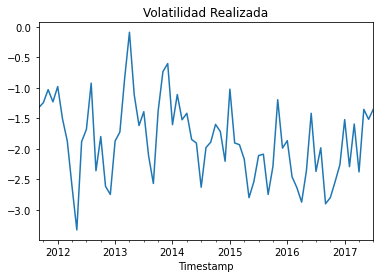

In [4]:
RV = Functions.realized_volatility(daily_data['log_return'], 'M')
log_RV = np.log(RV)
log_RV.plot(title = 'Volatilidad Realizada', legend = '')

### Tabla 2
Esta tabla informa las estadísticas descriptivas de las consultas de búsqueda estandarizadas, las consultas de búsqueda logarítmicas, la volatilidad realizada logarítmica, el volumen logarítmico y los rendimientos logarítmicos.

In [5]:
descriptive_stats = pd.DataFrame({
    'stan-SQ' : Functions.estadisticas(stan_SQ),
    'log-SQ' : Functions.estadisticas(log_SQ),
    'log-RV' : Functions. estadisticas(log_RV),
    'log-Volume':Functions.estadisticas(daily_data[['log_vol']]),
    'log-Returns': Functions.estadisticas(daily_data[['log_return']])
    }, 
    index = ['Mean', 'Std', 'Max', 'Min', 'Skew', 'Kurtosis']).T
descriptive_stats

,Mean,Std,Max,Min,Skew,Kurtosis
stan-SQ,1.000000,1.248152,6.542056,0.065421,2.886086,9.201655
log-SQ,-0.574311,1.132988,1.878252,-2.726919,-0.233386,-0.270912
log-RV,-1.857679,0.640661,-0.085345,-3.332693,0.161260,-0.226608
log-Volume,8.420200,1.648772,11.828248,-1.386294,-1.708923,4.133145
log-Returns,0.002791,0.043394,0.290839,-0.496253,-1.173508,16.700409


# Resultados Empíricos

## Resultados de vectores autorregresivos y respuesta de impulso

In [6]:
all_data = Functions.consolidate_data(daily_data, log_SQ, log_RV)

### Tabla 3

Primer ejercicio: usando el criterio de información BIC para elegir el número de lags

In [15]:
results_1, results_2, results_3, lags_mod1, lags_mod2, lags_mod3  = Models.modelos(all_data, [])
Models.tabla_resultados(results_1, results_2, results_3, lags_mod1, lags_mod2, lags_mod3)

Model 1             Model 2              Model 3          
               RV_t      SQ_t      SQ_t      VO_t        R_t      SQ_t
SQ_t-1      0.0059   0.8855**  0.7797**  -0.0231   -0.0727**  0.8853**
RV_t-1     0.4835**  -0.0168                                          
VO_t-1                          0.1125*  0.8967**                     
R_t-1                                                0.1504    0.668**
Constant  -0.9653**  -0.0581   -1.4383*  1.3049**    0.0407   -0.0873

In [16]:
Models.granger_test(all_data, max_lag = 1)

,F,p-value,Significancia
RV does not Granger Cause SQ,0.026516,0.871144,
Volume does not Granger Cause SQ,3.723627,0.057948,*
Returns does not Granger Cause SQ,12.511472,0.000746,**
SQ does not Granger Cause RV,0.008700,0.925969,
SQ does not Granger Cause Volume,0.116245,0.734226,
SQ does not Granger Cause Returns,5.122037,0.026919,**


Segundo ejercicio: usando los mismos lags que se usan en el paper

In [17]:
results_1, results_2, results_3, lags_mod1, lags_mod2, lags_mod3  = Models.modelos(all_data, [7,7,5])
Models.tabla_resultados(results_1, results_2, results_3, lags_mod1, lags_mod2, lags_mod3)

Model 1             Model 2             Model 3           
               RV_t      SQ_t      SQ_t      VO_t       R_t       SQ_t
SQ_t-1     0.3054**  0.7702**   0.791**    0.119   -0.0009    0.6293**
SQ_t-2     -0.1977    0.1035   -0.0232   -0.2516*  -0.0983     0.0966 
SQ_t-3      0.1766    0.1751   -0.0046    0.1712   -0.0186      0.097 
SQ_t-4     -0.0888   -0.1601   -0.2025   -0.0312    0.0934     0.0734 
SQ_t-5     -0.3794*    -0.09   -0.0047   -0.1896   -0.0586     0.0521 
SQ_t-6      0.2831    0.0487    0.0895    0.2049                      
SQ_t-7     -0.1072    0.0731    0.0691   -0.0409                      
RV_t-1     0.3027**   0.1181                                          
RV_t-2      0.1104   -0.1753                                          
RV_t-3     -0.2526   -0.1241                                          
RV_t-4      0.0422   -0.0605                                          
RV_t-5      0.1538    0.0117                                          
RV_t-6     -0.0235    0.0168                                          
RV_t-7      0.2262    0.1388                                          
VO_t-1                           0.017   0.5393**                     
VO_t-2                          0.0185   0.4157**                     
VO_t-3                          0.1766   -0.1994                      
VO_t-4                          0.0384    0.0378                      
VO_t-5                         -0.0913   -0.0546                      
VO_t-6                           -0.18   -0.0814                      
VO_t-7                          0.2331    0.1385                      
R_t-1                                               0.0729    0.8622**
R_t-2                                               0.0149     0.2051 
R_t-3                                              -0.0364     0.3654 
R_t-4                                              -0.0866     0.1931 
R_t-5                                              -0.0954   -0.4624**
Constant  -0.8795**  -0.1332   -2.6604*  2.5938**   0.0633    -0.0624

In [18]:
Models.granger_test(all_data, max_lag = 7)

,F,p-value,Significancia
RV does not Granger Cause SQ,0.605962,0.748001,
Volume does not Granger Cause SQ,0.861614,0.543258,
Returns does not Granger Cause SQ,3.030957,0.010121,**
SQ does not Granger Cause RV,1.585682,0.162535,
SQ does not Granger Cause Volume,0.877935,0.530849,
SQ does not Granger Cause Returns,1.873408,0.094901,*


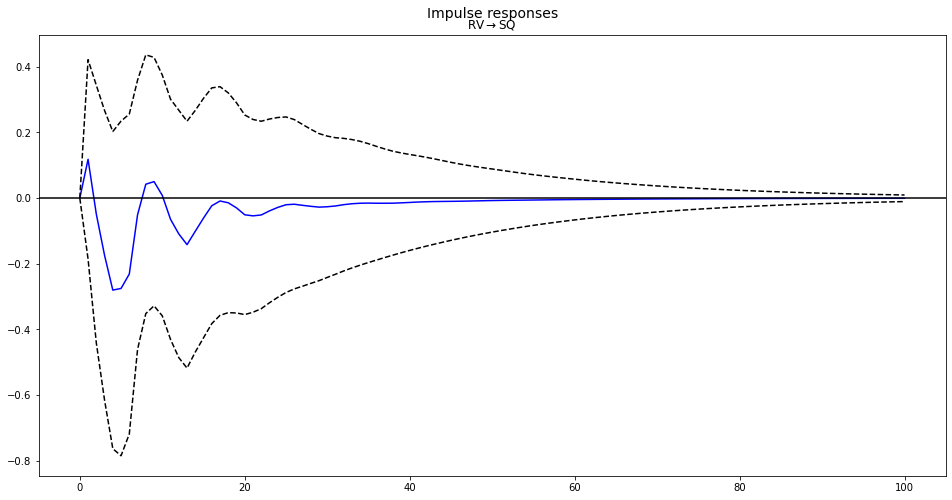

In [19]:
fig = results_1.irf(100).plot(impulse = 'RV', response = 'SQ', figsize = (14,7))

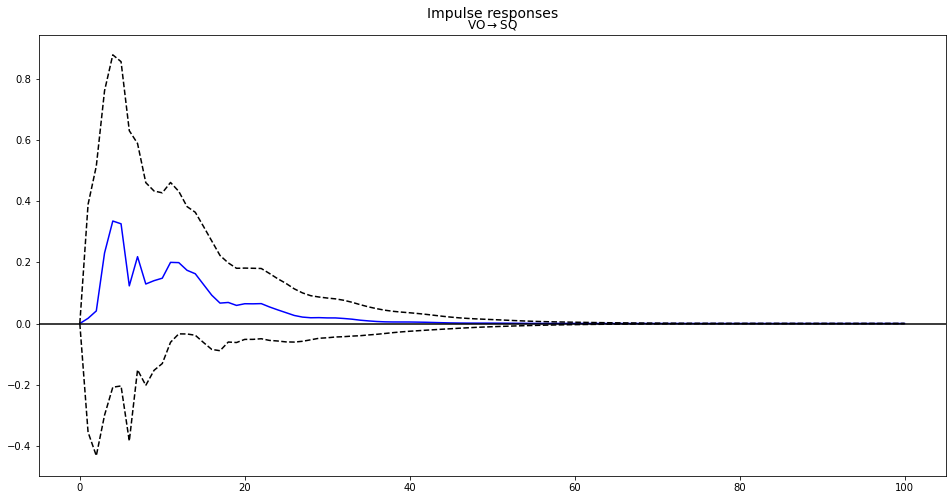

In [20]:
fig = results_2.irf(100).plot(impulse = 'VO', response = 'SQ', figsize = (14,7))

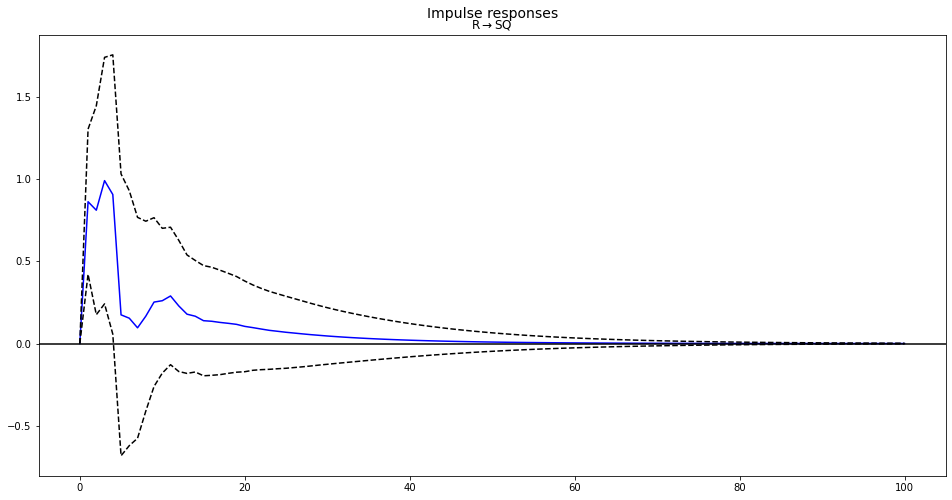

In [21]:
fig = results_3.irf(100).plot(impulse = 'R', response = 'SQ', figsize = (14,7))

## Resultados para las submuestras

Se parte la muestra en la fecha 28 de Octubre del 2013 y se corren de nuevo los modelos

### Tabla 4
Resultados para la primera sección de datos
Primer ejercicio: usando el criterio de información BIC para elegir el número de lags

In [23]:
results_1, results_2, results_3, lags_mod1, lags_mod2, lags_mod3  = Models.modelos(all_data.loc[all_data.index < '2013-10-28',:], [])
Models.tabla_resultados(results_1, results_2, results_3, lags_mod1, lags_mod2, lags_mod3)

Model 1             Model 2             Model 3           
              RV_t      SQ_t      SQ_t      VO_t       R_t       SQ_t
SQ_t-1    -0.7449   -0.6193   0.6645**   -0.025   -0.4406    -0.8279 
SQ_t-2     1.8511    1.2803                        0.5143      1.292*
SQ_t-3    -1.2535   -1.3791                        0.1001     0.0198 
SQ_t-4    1.4454**   0.4779                       -0.6951    -0.7379 
SQ_t-5     -2.994   -2.8787                        0.2139     1.1234*
SQ_t-6     2.0045    2.4093                        0.2294     0.0462 
SQ_t-7     0.3047    0.1444                       -0.6623     -1.204 
RV_t-1     0.8413    2.1135                                          
RV_t-2     0.1378    0.5927                                          
RV_t-3    -0.6266    0.1424                                          
RV_t-4     0.0031    0.5257                                          
RV_t-5    -0.3135    0.8761                                          
RV_t-6     2.3513    2.5406                                          
RV_t-7    -1.4525   -1.5957                                          
VO_t-1                         0.0926   0.9317**                     
R_t-1                                               1.214    4.7739**
R_t-2                                              0.4274     0.9007 
R_t-3                                             -2.1713    -2.1192 
R_t-4                                              1.5996    4.4429**
R_t-5                                              0.6693    -0.1921 
R_t-6                                             -1.4874     -2.488 
R_t-7                                              1.4286     1.7305 
Constant   1.3829    7.1935   -1.5454    0.9094   -1.6077   -3.7605**

Segundo ejercicio: usando los mismos lags que se usan en el paper

In [24]:
results_1, results_2, results_3, lags_mod1, lags_mod2, lags_mod3  = Models.modelos(all_data.loc[all_data.index < '2013-10-28',:], [7,7,5])
Models.tabla_resultados(results_1, results_2, results_3, lags_mod1, lags_mod2, lags_mod3)

Model 1               Model 2             Model 3           
              RV_t      SQ_t        SQ_t      VO_t       R_t       SQ_t
SQ_t-1    -0.7449   -0.6193     -0.4708   -0.8056   -0.2442    -0.0969 
SQ_t-2     1.8511    1.2803      0.1131     0.552    0.1879     0.6115 
SQ_t-3    -1.2535   -1.3791     -0.1248    -0.165   -0.1372    -0.3697 
SQ_t-4    1.4454**   0.4779       0.717    0.9269   -0.0679     0.2636 
SQ_t-5     -2.994   -2.8787     -1.3484    -1.453*   0.0856     0.4883 
SQ_t-6     2.0045    2.4093      1.0093    1.2015                      
SQ_t-7     0.3047    0.1444      1.6762    1.1692                      
RV_t-1     0.8413    2.1135                                            
RV_t-2     0.1378    0.5927                                            
RV_t-3    -0.6266    0.1424                                            
RV_t-4     0.0031    0.5257                                            
RV_t-5    -0.3135    0.8761                                            
RV_t-6     2.3513    2.5406                                            
RV_t-7    -1.4525   -1.5957                                            
VO_t-1                           2.4052    1.8407                      
VO_t-2                           0.8497    0.3822                      
VO_t-3                           0.1671   -0.1608                      
VO_t-4                          -2.3561   -1.4476                      
VO_t-5                           -1.612   -1.2053                      
VO_t-6                           2.2895     2.546                      
VO_t-7                          -0.0872   -0.6462                      
R_t-1                                               0.9749**   3.2182**
R_t-2                                               -0.1667    -0.5584 
R_t-3                                               -0.4308     0.8447 
R_t-4                                                0.9125    2.4985**
R_t-5                                               -0.1986   -1.7082**
Constant   1.3829    7.1935   -17.2743**   0.0042   -0.3135    -0.7008

In [25]:
Models.granger_test(all_data.loc[all_data.index < '2013-10-28',:], max_lag = 7)

,F,p-value,Significancia
RV does not Granger Cause SQ,1.359865,0.486998,
Volume does not Granger Cause SQ,1.050276,0.569225,
Returns does not Granger Cause SQ,2.428482,0.322471,
SQ does not Granger Cause RV,6.205083,0.145773,
SQ does not Granger Cause Volume,0.467129,0.811825,
SQ does not Granger Cause Returns,0.552365,0.767569,


### Tabla 5
Resultados para la segunda sección de datos
Primer ejercicio: usando el criterio de información BIC para elegir el número de lags

In [26]:
results_1, results_2, results_3, lags_mod1, lags_mod2, lags_mod3  = Models.modelos(all_data.loc[all_data.index >= '2013-10-28',:], [])
Models.tabla_resultados(results_1, results_2, results_3, lags_mod1, lags_mod2, lags_mod3)

Model 1             Model 2             Model 3          
               RV_t      SQ_t      SQ_t      VO_t       R_t      SQ_t
SQ_t-1      0.2456*  0.6971**  0.7338**   0.0189   -0.0903   0.7387**
RV_t-1      0.2883*   0.0987                                         
VO_t-1                          0.0359   0.6799**                    
R_t-1                                               0.0382   0.6404**
Constant  -1.3958**   0.2255   -0.4231    4.044**   0.0572   -0.0109

In [29]:
Models.granger_test(all_data.loc[all_data.index >= '2013-10-28',:], max_lag = 1)

,F,p-value,Significancia
RV does not Granger Cause SQ,0.419700,0.520613,
Volume does not Granger Cause SQ,0.087031,0.769440,
Returns does not Granger Cause SQ,10.464458,0.002374,**
SQ does not Granger Cause RV,3.200488,0.080830,*
SQ does not Granger Cause Volume,0.030670,0.861820,
SQ does not Granger Cause Returns,1.627967,0.208996,


Segundo ejercicio: usando los mismos lags que se usan en el paper

In [27]:
results_1, results_2, results_3, lags_mod1, lags_mod2, lags_mod3  = Models.modelos(all_data.loc[all_data.index >= '2013-10-28',:], [7,7,7])
Models.tabla_resultados(results_1, results_2, results_3, lags_mod1, lags_mod2, lags_mod3)

Model 1              Model 2             Model 3          
              RV_t       SQ_t      SQ_t      VO_t       R_t      SQ_t
SQ_t-1     0.4064     0.2966     0.282    0.0719     0.045    0.2274 
SQ_t-2    -0.1392     0.0849     0.102   -0.4054*  -0.0327    0.1983 
SQ_t-3     0.0638      0.085   -0.0101    0.0946   -0.0161    0.2501 
SQ_t-4    -0.1678     0.1371    0.0815   -0.0693    0.1408   -0.1158 
SQ_t-5     -0.049     0.1534    0.0911    -0.017    0.0451    0.0337 
SQ_t-6     0.2122     0.2286    0.1763    0.2971    -0.062    0.0999 
SQ_t-7    -0.0083    -0.1757   -0.1541   -0.0508   -0.1338*  -0.0521 
RV_t-1     0.1618    -0.0835                                         
RV_t-2     0.2103     0.0474                                         
RV_t-3    -0.2583    -0.2933*                                        
RV_t-4     0.0208    -0.0709                                         
RV_t-5     0.0864    -0.1901                                         
RV_t-6     -0.127    -0.0955                                         
RV_t-7     0.1266    -0.1237                                         
VO_t-1                         -0.1322   0.5726**                    
VO_t-2                          0.1314    0.4264*                    
VO_t-3                         -0.1404   -0.3305                     
VO_t-4                         -0.0244   -0.0155                     
VO_t-5                         -0.0591   -0.0064                     
VO_t-6                         -0.0987   -0.1045                     
VO_t-7                         -0.0996    0.0306                     
R_t-1                                              -0.0983   1.1583**
R_t-2                                              -0.1642    0.1999 
R_t-3                                               0.0955   0.9533**
R_t-4                                               0.2488     -0.32 
R_t-5                                               0.1877    0.1909 
R_t-6                                               0.0704   -0.0323 
R_t-7                                               0.0689   -0.2336 
Constant   -1.577*  -1.7193**  5.2458**  5.3336**   0.0521   -0.1234

In [28]:
Models.granger_test(all_data.loc[all_data.index >= '2013-10-28',:], max_lag = 7)

,F,p-value,Significancia
RV does not Granger Cause SQ,1.347829,0.271902,
Volume does not Granger Cause SQ,1.173519,0.354065,
Returns does not Granger Cause SQ,3.178904,0.015854,**
SQ does not Granger Cause RV,0.586679,0.760068,
SQ does not Granger Cause Volume,0.853704,0.555484,
SQ does not Granger Cause Returns,1.036513,0.432369,
